# Survival Analysis for Individual Patient Data of Acid Sphingomyelinase Deficiency (ASMD)


## Background

Sanofi engaged ISMS to develop a patient pool model for Acid Sphingomyelinase Deficiency (ASMD). This disease exhibits significant variability in key parameters, including clinical severity, age of onset, and survival. The variability extends across subtypes (A, A/B, and B), with subtype B further differing by pediatric versus adult onset.

Using mean values to model these parameters would overlook this heterogeneity, leading to loss of detail in patient pool classifications (onset, diagnosis, survival) across age groups. To address this, a probabilistic approach was implemented to better capture variability within and between subgroups.

## Input Data

The age-at-diagnosis dataset was extracted from the [article](https://www.sciencedirect.com/science/article/pii/S1096719216300580). 

In [2]:
# Load age at diagnosis dataset in Excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lifelines


In [3]:
diagnosis_age_df = pd.read_excel('age-at-diagnosis-asmd.xlsx')

In [4]:
diagnosis_age_df.head()

,Time since birth (year),Diagnosis,AB,CH
0,0.10,1,1,0
1,0.28,1,1,0
2,0.36,1,1,0
3,0.45,1,1,0
4,0.45,1,1,0


## Perform KM survival analysis

In [5]:
from lifelines import KaplanMeierFitter # for Kaplan Meier estimator
from matplotlib import pyplot as plt
from lifelines.utils import median_survival_times 

/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_57280/4218525001.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


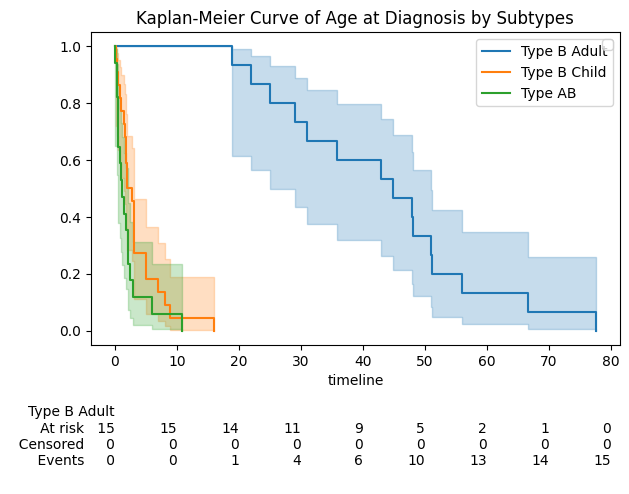

In [13]:
ax = plt.subplot(111) # To put the legend outside the plot 


# Subset by subtypes - index the rows with the condition
# AB == 0 and CH == 0 means type B adult
# AB == 0 and CH == 1 means type B child
# AB == 1 means type AB
type_b_adult = (diagnosis_age_df["AB"] == 0) & (diagnosis_age_df["CH"] == 0)
type_b_child = (diagnosis_age_df["AB"] == 0) & (diagnosis_age_df["CH"] == 1)
type_ab = (diagnosis_age_df["AB"] == 1)

# Instantiate the class to create an object
kmf = KaplanMeierFitter()  

# Define the time and event
T = diagnosis_age_df["Time since birth (year)"] 
E = diagnosis_age_df["Diagnosis"]  

# Fit the data into the model
kmf.fit(T[type_b_adult], event_observed=E[type_b_adult], label="Type B Adult")
kmf.plot_survival_function(ax=ax, at_risk_counts=True) 

kmf.fit(T[type_b_child], event_observed=E[type_b_child], label="Type B Child")
kmf.plot_survival_function(ax=ax, at_risk_counts=False)

kmf.fit(T[type_ab], event_observed=E[type_ab], label="Type AB")
kmf.plot_survival_function(ax=ax, at_risk_counts=False)

plt.tight_layout()
plt.title("Kaplan-Meier Curve of Age at Diagnosis by Subtypes")
plt.legend(loc="best")

## Compare the survival curves of different subtypes using log-rank test

In [15]:
from lifelines.statistics import logrank_test 

In [17]:
# Test at the 5% significance level 
diag_log_rank = logrank_test(T[type_b_adult],
                             T[type_b_child],
                             E[type_b_adult],
                             E[type_b_child],
                             alpha=0.05)

In [18]:
diag_log_rank.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.05 <0.005     29.70

## Perform parametric regression analysis to estimate the survival function

Fit various parametric models to the data and compare the goodness of fit using AIC, including Weibull, Gompertz, Exponential, and Log-normal models.

In [19]:
from lifelines import (WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, NelsonAalenFitter, PiecewiseExponentialFitter,
                       GeneralizedGammaFitter, SplineFitter)

<Axes: >

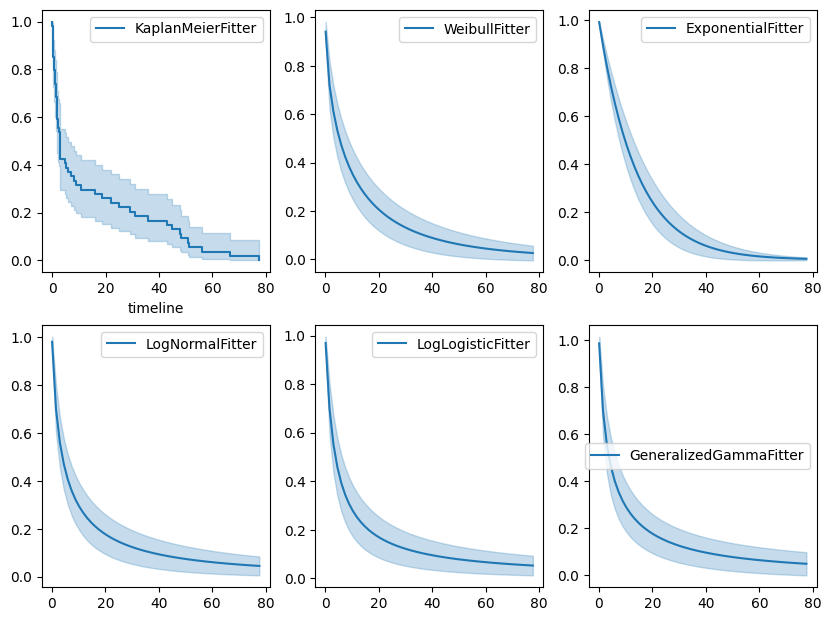

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7.5))

# Kaplan-Meier Fitter 
kmf_surv = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter') 
kmf_surv.plot_survival_function(ax=axes[0][0])

# Weibull Fitter
wbf_surv = WeibullFitter().fit(T, E, label='WeibullFitter')
wbf_surv.plot_survival_function(ax=axes[0][1])

# Exponential Fitter
exf_surv = ExponentialFitter().fit(T, E, label='ExponentialFitter')
exf_surv.plot_survival_function(ax=axes[0][2])

# Log-Normal Fitter
lnf_surv = LogNormalFitter().fit(T, E, label='LogNormalFitter')
lnf_surv.plot_survival_function(ax=axes[1][0])

# Log Logistic Fitter
llf_surv = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
llf_surv.plot_survival_function(ax=axes[1][1])

# Generalized Gamma Fitter
ggf_surv = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
ggf_surv.plot_survival_function(ax=axes[1][2])